In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd  
import importlib
import os
import numpy as np
from skimage import measure
from ipywidgets import interact
from ipywidgets import interact_manual
from IPython.display import display
from ipywidgets import widgets

In [2]:
import ipynb.fs.full.wspFFA as wspFirefly
import ipynb.fs.full.wspCS as wspCuckooSearch
import ipynb.fs.full.wspKH as wspKrillHerd
import ipynb.fs.full.wspEHO as wspElephantHerding
import ipynb.fs.full.wspABC as wspArtificialBeeColony

import ipynb.fs.full.plotGraph as plotGraph
import ipynb.fs.full.wspMultithreshold as wspMultithreshold
import ipynb.fs.full.dicomHandler as dicomHandler

importlib.reload(wspFirefly)
importlib.reload(wspCuckooSearch)
importlib.reload(wspKrillHerd)
importlib.reload(wspElephantHerding)
importlib.reload(wspArtificialBeeColony)

importlib.reload(plotGraph)
importlib.reload(wspMultithreshold)
importlib.reload(dicomHandler)

<module 'ipynb.fs.full.dicomHandler' (/mnt/6884ACCB84AC9CD6/OneDrive - FEI/Aulas/Graduacao/8 - Semestre/CC8421 - TRABALHO FINAL DE CURSO II/image-segmentation/dicomHandler.ipynb)>

In [3]:
folder_dir = "../Database/2EFVJVCN/"
file = "I1680000"
bio_algorithms = 'FFA'
dimension = 2
q = 1

In [4]:
image = folder_dir + file

In [5]:
dicom_image, pixel_array = dicomHandler.read_dicom_image(image)

In [9]:
dicom_image

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 168
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.105159.30000021013010280633300022620
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113704.7.0.2
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.105159.30000021013010280633300022620
(0008, 0020) Study Date                          DA: '20210130'
(0008, 0021) Series Date          

In [7]:
dicom_image.RescaleIntercept

'-1024.0'

In [8]:
dicom_image.RescaleSlope

'1.0'

In [5]:
dicom_image, pixel_array = dicomHandler.read_dicom_image(image)

transformed_pixel_array = dicomHandler.image_transformation(pixel_array)

original_image = pixel_array.copy()

print(pixel_array.min(), pixel_array.max())
    
hu_image = dicomHandler.transform_to_hu(dicom_image, transformed_pixel_array)

print(hu_image.min(), hu_image.max())

hist, bin_edges, best_thresholds, img_thres = wspMultithreshold.wspMultithreshold(hu_image, bio_algorithms, dimension, q)

0 2946
-1024.0 1922.0


In [6]:
high_intensity = wspMultithreshold.get_high_intensity_pixels(img_thres)

print(high_intensity.min(), high_intensity.max())

pixel_array = dicomHandler.transform_to_pixel_array(dicom_image, high_intensity)

print(pixel_array.min(), pixel_array.max())

hard_tissue = wspMultithreshold.get_largests_regions(pixel_array, original_image)

print(hard_tissue.min(), hard_tissue.max())

-1024.0 1923.0
-1024.0 1923.0
0 2947
0 2947


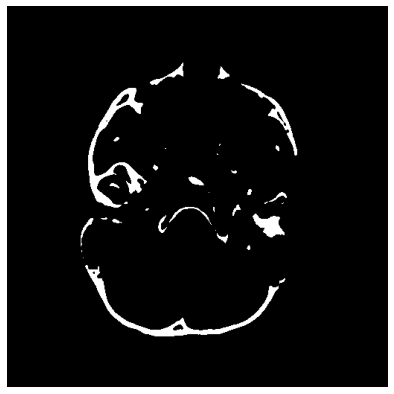

In [7]:
dicomHandler.show_dicom_image(pixel_array)

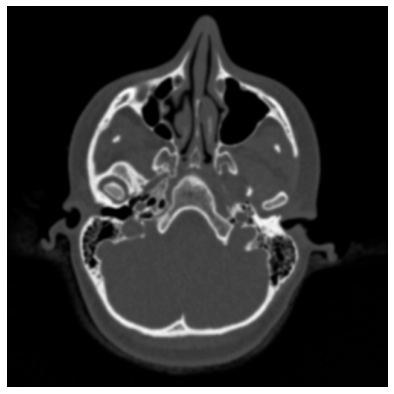

In [8]:
dicomHandler.show_dicom_image(hu_image)

In [9]:
min_val, max_val = original_image.min(), original_image.max()
print(min_val, max_val)

0 2946


In [10]:
org = original_image.copy()

In [11]:
mask = np.where(pixel_array==pixel_array.max(), False, True)

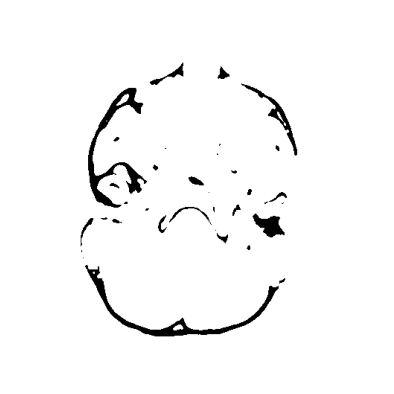

In [12]:
dicomHandler.show_dicom_image(mask)

In [13]:
org[mask] = org.max()

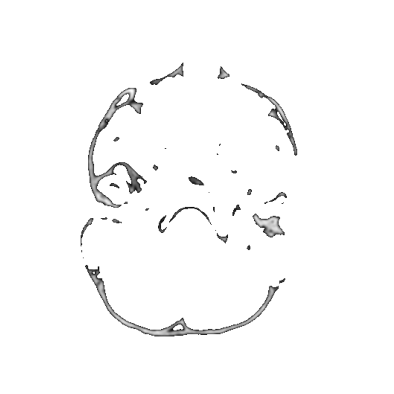

In [14]:
dicomHandler.show_dicom_image(org)

In [15]:
from skimage import data, util, measure

def region_stdev(region, intensities):
    return np.std(intensities[region])

label_image = measure.label(pixel_array)
props = measure.regionprops_table(label_image, original_image, properties=['area', 'intensity_mean'], extra_properties=[region_stdev])

table = pd.DataFrame(props)
X_train = table.values.tolist()
print(table['area'].idxmax())

#sorted_table = table.sort_values(by='area', ascending=False)
#sorted_table.reset_index(drop=True, inplace=True)
#sorted_table.rename(columns={'area': 'Area', 'intensity_mean': 'Mean', 'region_stdev': 'Std'})

3


In [16]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=2).fit(X_scaled)

included_labels = kmeans.labels_

In [18]:
included_labels

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [19]:
def get_largest_region(pixel_array):
    max_value = pixel_array.max()
    min_value = pixel_array.min()

    labels_mask = measure.label(pixel_array)

    regions = measure.regionprops(labels_mask)
    #regions.sort(key=lambda x: x.area, reverse=True)
    
    if len(regions) > 1:
        for index in range(len(regions)):
            if not included_labels[index]:
                labels_mask[regions[index].coords[:,0], regions[index].coords[:,1]] = min_value

    labels_mask[labels_mask != min_value] = max_value
    mask = labels_mask

    return mask.astype(np.int16)

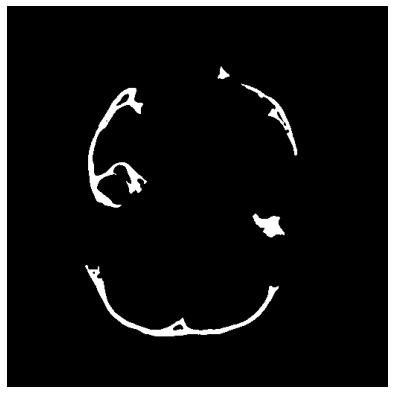

In [20]:
teste = get_largest_region(pixel_array)
dicomHandler.show_dicom_image(teste)